# SHOR with multiple errors (random pos.)


In [99]:
import qiskit.quantum_info as qi
from qiskit import Aer
from qiskit import execute, transpile, assemble
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute
from qiskit.providers.aer import QasmSimulator
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info.operators import Operator
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit.visualization import array_to_latex
from qiskit.providers.aer.library import SaveDensityMatrix
from qiskit.quantum_info import Statevector
from random import sample
import numpy as np
from numpy import linalg
from numpy import pi
from sympy import *
from sympy import factorint
from fractions import Fraction
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import pickle
plt.rc('figure', figsize=(16, 6))

In [100]:
def check(number):
    if number % 2 == 0:
        print("Even, 2 is a divisor")
        return
        
    if isprime(number) == True:
        print("Prime number")
        return
    
    factorization = factorint(number)
    for i in range(len(factorization.keys())):
        p = list(factorization)[i]
        q = list(factorization.values())[i]
        if isprime(p) and q != 1:
            print("Prime Power: %i^%i, %i is a divisor" % ( p, q, p))
            return
    
    y = random.randrange(2, number - 1)
    a = math.gcd(y, number)
    if a > 1:
        print("Divisor: a = %i" %(a))
        return 
        
    else:
        print("y = %i and N = %i are coprime - r well defined" %  (y, N))
        return 
    

In [101]:
def mod_exp(n, y, N, power):
    dim = 2**n
    matrix_0 = np.zeros((dim, dim))
    
    for i in range(N):
        j = (i*y)%N
        matrix_0[j][i]=1
             
    for ii in range(N, dim):
        matrix_0[ii][ii] = 1
             
    temp = matrix_0
    for iii in range(power):
        matrix = np.dot(temp, temp)
        temp = matrix
        
    U = UnitaryGate(temp)
    
    U.name = "%i^%i mod %i" % ( y, 2**power, N)
    c_U = U.control()
    return c_U

In [102]:
def errori(circuit, position, n):
    epsilon = 0.5                                              
    extracted = random.uniform(0, 1)
    position = random.randint(0, n)
    
    if (extracted < epsilon):  
        circuit.x(position)   
    else:
        circuit.z(position)
    return circuit                           

In [103]:
def qft_rotations(circuit, n, n_max,  case, position):
    tmp = n_max - case 
    if n == 0:
        return circuit
    n -= 1    

    if n  >=  tmp:   
        errori(circuit, position, n_max) 
        if n == tmp: 
            circuit.id(position)    
    circuit.h(n)   
    
    for qubit in range(n):
        circuit.cp(np.pi/2**(n-qubit), qubit, n)

    qft_rotations(circuit, n, n_max, case, position)

In [104]:
def swap_registers(circuit, n):
    
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)

In [105]:
def qft(circuit, n, n_max, case, position):
    qft_rotations(circuit, n, n_max, case, position)

    if case >= n + 1:
        errori(circuit, position, n_max)
        if case == n + 1:
            circuit.id(position)
        
    swap_registers(circuit, n)    

    if case >= n + 2:
        errori(circuit, position , n_max)
        if case == n + 2:
            circuit.id(position)
        
    if case >= 0:
        pass
        
    if case > n + 2:
        print('Error: case value incorrect')
    return circuit

In [112]:
coprimes = [2, 4, 7, 8, 11, 13, 14] #----------------------------------------------
N = 15
repetitions = 30

plot = []
n = math.ceil(math.log(N,2))

for rep in range(repetitions):
    case = 0 #random.randint(0, n+2 + 1)
    y = coprimes[random.randint(0, 6)]
    print(rep)
    position = random.randint(0, 2*n)
    
    control = QuantumRegister(2*n, 'r1')
    target  = QuantumRegister(n, 't1')
    classic = ClassicalRegister(2*n, 'c')
    circuit = QuantumCircuit(control, target, classic)
    circuit.h(range(2*n))
    circuit.x(2*n + n -1)

    for q in range(2*n):
        #if case >= n + 1:
        #errori(circuit, position, n)
        #circuit.id(position)
        circuit.append(mod_exp(n, y, N, q),     
                 [q] + [i+2*n for i in range(n)])    
    circuit.save_density_matrix()

    qft(circuit, n, n, case, position) 
    circuit.measure(range(2*n), range(2*n))   

    circuit.draw(output = 'mpl')     

    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(circuit, aer_sim)
    qobj = assemble(t_qc)                             
    results = aer_sim.run(qobj,shots = 1).result()          

    counts = results.get_counts()
    density_matrix = results.data().get('density_matrix')
    labels = []
    for i in range(len(counts)):
        labels.append(   int(list(counts.keys())[i], 2 )   )
    new_counts = dict(zip(labels,list(counts.values()) ))
    density_matrix = np.asarray(density_matrix)

    n_count = 2*n
    rows, measured_phases = [], []
    for output in counts:
        decimal = int(output, 2)                       
        phase = decimal/(2**n_count)                   
        measured_phases.append(phase)
                                                       
        rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                     f"{decimal}/{2**n_count} = {phase:.2f}"])                                                      
    headers=["Register Output", "Phase"]
    df = pd.DataFrame(rows, columns=headers)

    rows = []
    period = []
    for phase in measured_phases:
        frac = Fraction(phase).limit_denominator(15)
        rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
        period.append(frac.denominator)

    headers=["Phase", "Fraction", "Guess for r"]
    df = pd.DataFrame(rows, columns=headers)

    r = max(period)
    guesses = [gcd(y**(r//2)-1, N), gcd(y**(r//2)+1, N)]
    plot.append(guesses)
    
    #print('case = ', case, 'fact = ',guesses)
    #print(df)
    df = 0
    repetitions += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [107]:
df_prova

,Phase,Fraction,Guess for r
0,0.066406,1/15,15


[0.23333333 0.36666667 0.4       ]
0 [1, 6, 9, 2, 10, 2]


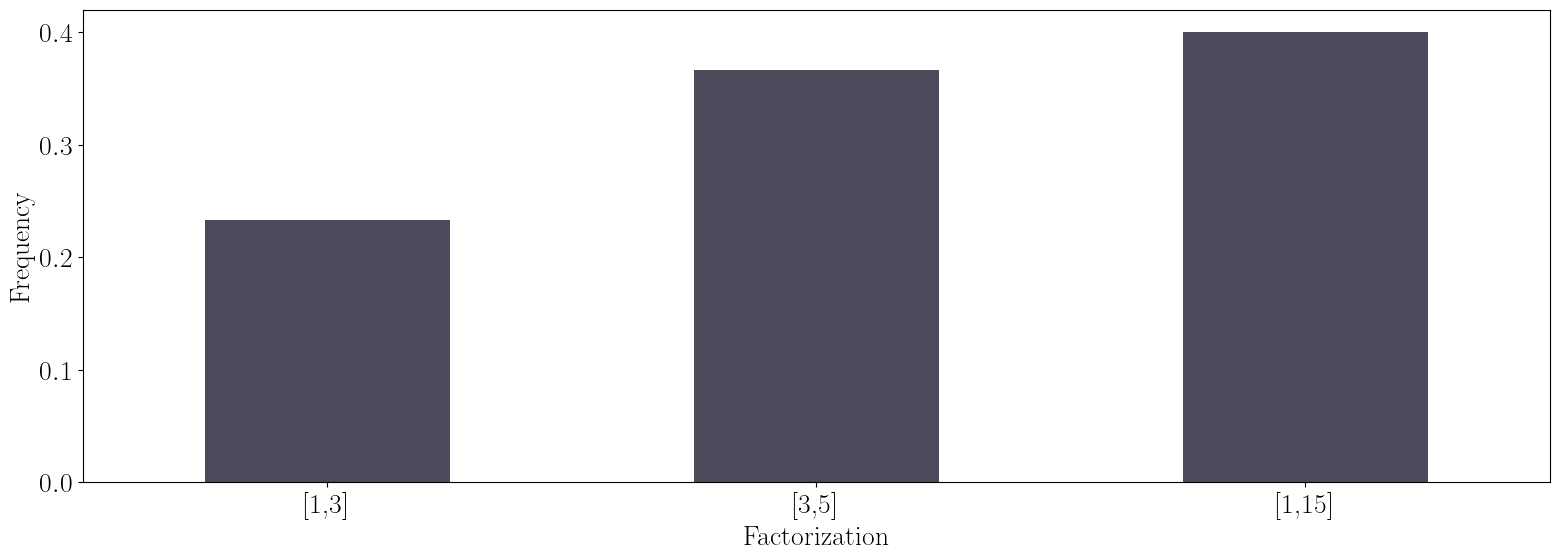

In [113]:
labels = [[1,3], [3,1], [3,5], [5,3], [15,1], [1,15] ]
counts = [0, 0, 0, 0, 0, 0]
frequencies = np.zeros(len(counts))
data = plot
color_bars = '#4C495A'

for i in range(len(data)):
    for ii in range(len(labels)):
        if data[i] == labels[ii]:
            counts[ii] += 1
          
for i in range(len(counts)): 
    frequencies[i] = counts[i]/repetitions

frequenciesBIS = np.zeros(3)

repetitions = 30    #--------------------------------------------------------------------------------
for i in range(len(frequenciesBIS)):
    #for i in range(ii, len(counts), 2):
    frequenciesBIS[i] = (counts[2*i] + counts[2*i+ 1])/repetitions
    
print(frequenciesBIS)

freq_series = pd.Series(frequenciesBIS)
names = ('[1,3]', '[3,5]', '[1,15]')

fig = freq_series.plot(kind='bar', color = color_bars)
fig.set_xlabel("Factorization")
fig.set_ylabel('Frequency')
fig.set_xticklabels(names, rotation = 0)
params = {'text.usetex' : True, 'font.size' : 20, 'font.family' : 'serif'}
plt.rcParams.update(params)
plt.tight_layout()

print(case, counts)

#plt.savefig('shor_multiple_ideal_qft.pdf', format = 'pdf') 
#pickle.dump(frequencies, open('shor_noisy_multiple_errors.pkl', 'wb'))

In [1]:
ideal = [0.23333333, 0.36666667, 0.4]
case5 = [0.26666667, 0.26666667, 0.46666667]
case5MOD = [0.43333333, 0.23333333, 0.33333333]

plt.plot(ideal, case5, case5MOD)

NameError: name 'plt' is not defined

In [110]:
coprimes = [2, 4, 7, 8, 11, 13, 14]
y = coprimes[random.randint(0, 6)]
print(type(y))


<class 'int'>


In [115]:
circuit.draw(fold = -1, output = 'mpl')  

RuntimeError: latex was not able to process the following string:
b'13^1 mod 15'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../ca6d33c66360bb9e3c11c241c3d68870.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.10) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(../ca6d33c66360bb9e3c11c241c3d68870.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-09-28>
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))

(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/underscore\underscore.s
ty) (C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\giuli\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file ca6d33c66360bb9e3c11c241c3d68870.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.29 {\obeylines\rmfamily 13^
                             1 mod 15}%
No pages of output.
Transcript written on ca6d33c66360bb9e3c11c241c3d68870.log.




<Figure size 4229.24x1120.39 with 1 Axes>